Based on houses sales data, estimate house prices. Make a hierarchical regression model. The hierarchy is house locations.

# Package

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math
import random
import statsmodels.api as sm

from numpy.linalg import inv
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Data

In [7]:
df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Hierarchy

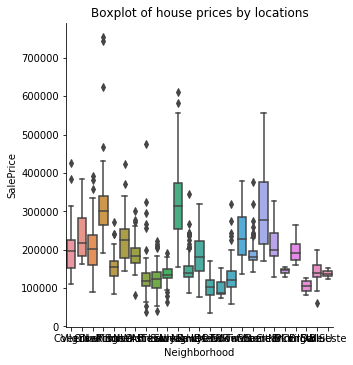

In [5]:
_ = sns.catplot(x = 'Neighborhood', y = 'SalePrice', kind = 'box', data = df)
_ = plt.title('Boxplot of house prices by locations')
plt.show()

# Model data

Make predictor (X) set. Apply centering to each variable by deducting mean, mean is the mean in each group, and make intercept terms. To perform hierarchical regression, make x list of each hierarchy.

In [8]:
X_COLUMNS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']
# preprocessing scale function shows warning if data type is int64
model_df = df[X_COLUMNS].astype(np.float64)

Neighborhood_list = np.unique(df['Neighborhood'])
m = len(Neighborhood_list)
X_list = []

for i in np.arange(0,m,1):
    temp = model_df.loc[df['Neighborhood'] == Neighborhood_list[i]]
    # centering, not scaling
    temp = preprocessing.scale(temp.values,
                               with_mean = True,
                               with_std = False)
    # adding intercept. do this after centering, otherwise intercept will be 0
    temp = sm.add_constant(temp)
    X_list.append(temp)
    
X = X_list

Make response (y) set

In [9]:
model_df = df['SalePrice']
y_list = []

for i in np.arange(0, len(Neighborhood_list),1):
    y_list.append(model_df.loc[df['Neighborhood'] == Neighborhood_list[i]])
    
y = y_list

# Functions for MCMC

In [11]:
def rmvnorm(n, mu, Sigma):
    E = np.random.normal(0, 1, n*len(mu))
    return np.dot(E, cholesky(Sigma, lower = False)) + mu

In [12]:
def rwish(nu0, S0):
    sS0 = cholesky(S0, lower = False)
    Z = np.dot(np.random.normal(0, 1, rwish_mean*rwish_var.shape[0]).reshape(rwish_mean, rwish_var.shape[0]), sS0)
    S = np.dot(np.transpose(Z), Z)
    return S

# Model

For priors in a hierarchical regression, estimate regression parameters in each hirarchy. The within-group sample variance is the square root of the residual sum of square divided by degree of freedom. Warning is, a group has little data, and can't estimate regression model. Need to resolve 0 coefficients for beta, and inf variance.

In [10]:
m = len(Neighborhood_list)
p = X[0].shape[1]
# BETA_LS = []
BETA_LS = np.zeros([m, p])
S2_LS = np.zeros(m)

for i in np.arange(0,m,1):
    # fit OLS to each group
    results = sm.OLS(y[i], X[i]).fit()
    
    # calculate parameters
    beta = results.params
    
    # calculate sample variance
    RSS = sum(results.resid ** 2)
    df = results.df_resid
    sample_variance = RSS/df
    
    # store outputs
#     BETA_LS.append(beta)
#     S2_LS.append(sample_variance)    
    BETA_LS[i] = beta
    S2_LS[i] = sample_variance  

C:\Users\yukic\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


# Markov chain Monte Carlo

Setup for MCMC (In calculating s2, omit inf variance).

In [13]:
p = X[0].shape[1]
theta = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
mu0 = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
nu0 = 1
s2 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
s20 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
eta0 = p + 2
Sigma = np.cov(BETA_LS, rowvar = False)
S0 = np.cov(BETA_LS, rowvar = False)
L0 = np.cov(BETA_LS, rowvar = False)
BETA = BETA_LS
iL0 = inv(L0)
iSigma = inv(Sigma)

N = np.zeros(m)
for i in np.arange(0,m,1):
    N[i] = len(X[i])

# MCMC setting and storing
random.seed(0)
S = 5000
S2_b = np.zeros(S)
THETA_b = np.zeros([S, p])
Sigma_ps = np.zeros([p, p])
BETA_ps = BETA * 0
SIGMA_PS = np.zeros([S, p * p])
BETA_pp = np.zeros([S, p])

In [14]:
for s in np.arange(0,S,1):

    # update beta_j
    for j in np.arange(0,m,1):
        Vj = inv(iSigma + np.dot(np.transpose(X[j]), X[j])/s2)
        Ej = np.dot(Vj, np.dot(iSigma, theta) + np.dot(np.transpose(X[j]), y[j])/s2)
        BETA[j] = rmvnorm(1, Ej, Vj)

    # update theta
    Lm = inv(iL0 + m * iSigma)
    mum = np.dot(Lm, np.dot(iL0, mu0) + np.dot(iSigma, pd.DataFrame(BETA).apply(sum, axis = 0)))
    theta = rmvnorm(1, mum, Lm)

    # update Sigma
    rwish_mean = eta0 + m
    rwish_var = inv(S0 + np.dot(np.transpose(BETA - theta), BETA - theta))
    iSigma = rwish(rwish_mean, rwish_var)

    # update s2
    RSS = 0
    for j in np.arange(0,m,1):
        RSS = RSS + sum((y[j] - np.dot(X[j], BETA[j])) ** 2)
    s2 = 1/np.random.gamma(shape = (nu0 + sum(N))/2, scale = 1/((nu0*s20+RSS)/2), size = 1)

    # store results
    S2_b[s] = s2
    THETA_b[s] = theta
    Sigma_ps = Sigma_ps + inv(iSigma)
    BETA_ps = BETA_ps + BETA
    SIGMA_PS[s] = np.matrix.flatten(inv(iSigma))
    BETA_pp[s] = rmvnorm(1, theta, inv(iSigma))

# MCMC result

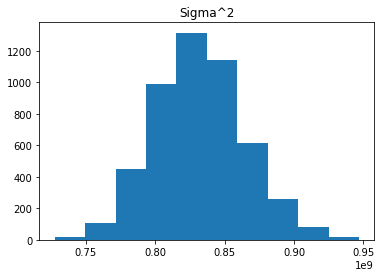

In [15]:
_ = plt.hist(S2_b)
_ = plt.title("Sigma^2")
plt.show()

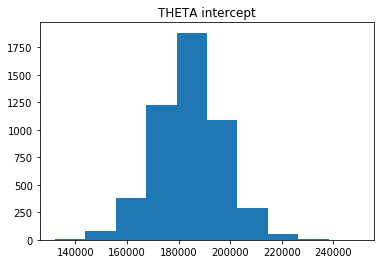

In [16]:
_ = plt.hist(THETA_b[:,0])
_ = plt.title("THETA intercept")
plt.show()

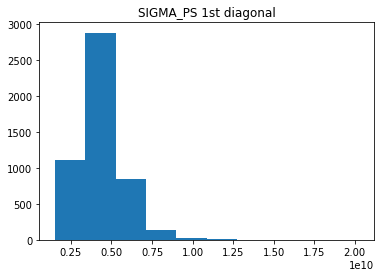

In [17]:
_ = plt.hist(SIGMA_PS[:,0])
_ = plt.title("SIGMA_PS 1st diagonal")
plt.show()

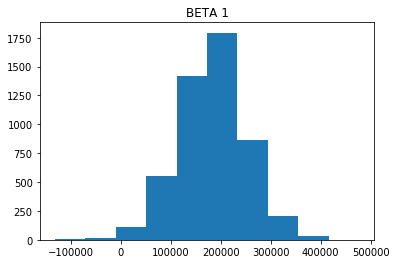

In [18]:
_ = plt.hist(BETA_pp[:,0])
_ = plt.title("BETA 1")
plt.show()

# MCMC diagnostics

Effective sample size and autocorrelation

# Test data

In [23]:
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Imputation missing values in test data

In [48]:
COLUMNS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars', 'Neighborhood']
X_test = test[COLUMNS]
print(X_test.shape)
print(X_test.isnull().sum())

(1459, 5)
OverallQual     0
YearBuilt       0
GrLivArea       0
GarageCars      1
Neighborhood    0
dtype: int64


In [49]:
# imputing missing values
COLUMNS = ['GarageCars']
test_temp = test[COLUMNS]
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
test_temp = imp_mean.fit_transform(test_temp)
test_temp = pd.DataFrame(test_temp, columns = COLUMNS)
print(test_temp.shape)
print(test_temp.isnull().sum())

(1459, 1)
GarageCars    0
dtype: int64


In [62]:
COLUMNS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'Neighborhood']
X_test = X_test[COLUMNS]
X_test = pd.concat([X_test, test_temp], axis = 1)
X_test.head()

,OverallQual,YearBuilt,GrLivArea,Neighborhood,GarageCars
0,5,1961,896,NAmes,1.0
1,6,1958,1329,NAmes,1.0
2,5,1997,1629,Gilbert,2.0
3,6,1998,1604,Gilbert,2.0
4,8,1992,1280,StoneBr,2.0


# Prediction

# Adjustment

Replace negative values predicted.

In [ ]:
test_pred = model.predict(X_test)
print(pd.Series(test_pred).describe())
test_pred = np.where(test_pred < 0, 0, test_pred)
print(pd.Series(test_pred).describe())

In [63]:
print('Type of pred', type(pred))
print('Length of pred', pred.shape)
print('Type of Id', type(test['Id']))
print('Length of Id', test['Id'].shape)
sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': pd.Series(test_pred)})
print(sub.head())
print(sub.describe())

NameError: name 'pred' is not defined

# Export prediction

In [ ]:
sub.to_csv('C:\\Users\\yukic\\Documents\\kaggle\\houseprices\\submission_19XXXX.csv', index = False)